# Protein complex analysis

**Goal** Determine if adding in protein complex information can clear up cycles in INDRA networks

Steps
- Where do we get complex info
    - INDRA
    - CORUM
    - Other
- Overlap between complexes and measured proteins
    - Do we see full complexes, partial complexes, ect
    - What about in INDRA networks
- How do we calculate correlation between multiple variables?
- Algorithm
- Open questions
    - How are complexes related to Up/Down regulation events in INDRA
        - Are complexes connected in these events
        - Do complexes correspond to highly connected areas of the graph
    - Will interventional targets be involved in complexes
    - How to numerically represent complexes
        - mean
        - sum
        - blah


In [171]:
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.decomposition import PCA

import MScausality.data_analysis.gene_set as gs

import matplotlib.pyplot as plt
%matplotlib inline

## Where do we get complex info

Right now just from CORUM bc easy flat file

This could (and probably should) be pulled from INDRA

In [3]:
complex_info = pd.read_csv("../../data/complex_data/humanComplexes.txt", sep="\t")

In [112]:
complex_info.head()

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,PubMed ID,Complex comment,Disease comment,Subunits comment,SWISSPROT organism,subunits(Protein name),subunits(Gene name),subunits(Gene name syn)
0,1,BCL6-HDAC4 complex,Human,None,U2OS osteosarcoma-derived UTA-L cells,P41182;P56524,604;9759,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,11929873,Transcriptional repression by BCL6 is thought ...,None,None,Homo sapiens (Human);Homo sapiens (Human),B-cell lymphoma 6 protein;Histone deacetylase 4,BCL6;HDAC4,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0288
1,2,BCL6-HDAC5 complex,Human,None,U2OS osteosarcoma-derived UTA-L cells,P41182;Q9UQL6,604;10014,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,11929873,Transcriptional repression by BCL6 is thought ...,None,None,Homo sapiens (Human);Homo sapiens (Human),B-cell lymphoma 6 protein;Histone deacetylase 5,BCL6;HDAC5,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0600
2,3,BCL6-HDAC7 complex,Human,None,U2OS osteosarcoma-derived UTA-L cells,P41182;Q8WUI4,604;51564,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,11929873,Transcriptional repression by BCL6 is thought ...,None,None,Homo sapiens (Human);Homo sapiens (Human),B-cell lymphoma 6 protein;Histone deacetylase 7,BCL6;HDAC7,BCL5 LAZ3 ZBTB27 ZNF51;HDAC7A
3,4,Multisubunit ACTR coactivator complex,Human,None,different human tissues and cancer cell lines,Q09472;Q92793;Q92831;Q9Y6Q9,2033;1387;8850;8202,MI:0004-affinity chromatography technology;MI:...,GO:0030374;GO:0004402,nuclear receptor coactivator activity;histone ...,None,None,9267036,Cofactor ACTR binds directly nuclear receptors...,None,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,Histone acetyltransferase p300;CREB-binding pr...,EP300;CREBBP;KAT2B;NCOA3,P300;CBP;PCAF;AIB1 BHLHE42 RAC3 TRAM1
4,10,Condensin I complex,Human,13S condensin complex,HeLa cells,O95347;Q15003;Q15021;Q9BPX3;Q9NTJ3,10592;23397;9918;64151;10051,MI:0004-affinity chromatography technology;MI:...,GO:0000279;GO:0030261;GO:0007059;GO:0051276;GO...,M phase;chromosome condensation;chromosome seg...,10.03.01.01.11;10.03.04.03;10.03.04.05;42.10.0...,M phase;chromosome condensation;chromosome seg...,11136719,None,None,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,Structural maintenance of chromosomes protein ...,SMC2;NCAPH;NCAPD2;NCAPG;SMC4,CAPE SMC2L1;BRRN BRRN1 CAPH KIAA0074;CAPD2 CNA...


In [87]:
# dump complexes of a single protein
complex_info = complex_info[complex_info["subunits(Gene name)"].str.contains(";")].reset_index(drop=True)

## Overlap between complexes and measured proteins

Basically look at all measured proteins and calculate overlap percentages.

In [114]:
experimental_data = pd.read_csv("../../data/Talus/processed_data/ProteinLevelData.csv")
experimental_data = gs.prep_msstats_data(experimental_data, gene_map=None, parse_gene=True)
corr_data = gs.gen_correlation_matrix(experimental_data, methods=["pearson"], abs_corr=True)

corr_data = corr_data["pearson"]
measured_proteins = corr_data.columns.values

Correlation matrix for pearson:


In [161]:
full_complex = list()
partial_complex = list()
percentage_tracker = list()
corr_tracker = dict()

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
    
for i in range(len(complex_info)):
    genes = complex_info.loc[i, "subunits(Gene name)"].split(";")
    overlap = intersection(genes, measured_proteins)

    if len(overlap) == len(genes):
        full_complex.append(complex_info.loc[i, "ComplexID"])
        percentage_tracker.append(1.)

        corr_tracker[complex_info.loc[i, "ComplexID"]] = np.nanmean(np.unique(corr_data.loc[overlap, overlap].values.flatten()))
    
    elif len(overlap) > 0:
        partial_complex.append(complex_info.loc[i, "ComplexID"])
        percentage_tracker.append(len(overlap) / len(genes))

        if len(overlap) > 1:
            corr_tracker[complex_info.loc[i, "ComplexID"]] = np.nanmean(np.unique(corr_data.loc[overlap, overlap].values.flatten()))

/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_92981/594704512.py:25: RuntimeWarning: Mean of empty slice
  corr_tracker[complex_info.loc[i, "ComplexID"]] = np.nanmean(np.unique(corr_data.loc[overlap, overlap].values.flatten()))


(array([  5.,  13.,  24.,  66., 108.,  22., 371.,  49.,  25., 466.,  17.,
         55.,  19., 220., 103.,  44.,  18.,  27.,   3., 331.]),
 array([0.01282051, 0.06217949, 0.11153846, 0.16089744, 0.21025641,
        0.25961538, 0.30897436, 0.35833333, 0.40769231, 0.45705128,
        0.50641026, 0.55576923, 0.60512821, 0.65448718, 0.70384615,
        0.75320513, 0.8025641 , 0.85192308, 0.90128205, 0.95064103,
        1.        ]),
 <BarContainer object of 20 artists>)

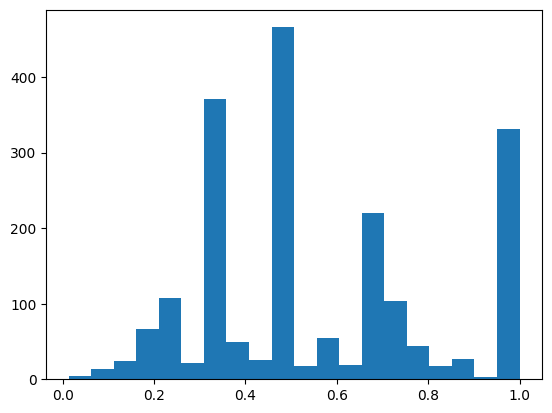

In [155]:
fig, ax = plt.subplots()

ax.hist(percentage_tracker, bins=20)

(array([ 72., 114., 122., 164., 112., 128., 137.,  80.,  44.,  42.,  22.,
         21.,  21.,   9.,   4.,   5.,   3.,   5.,   0.,   1.]),
 array([1.23770736e-04, 5.01175822e-02, 1.00111394e-01, 1.50105205e-01,
        2.00099017e-01, 2.50092828e-01, 3.00086640e-01, 3.50080451e-01,
        4.00074262e-01, 4.50068074e-01, 5.00061885e-01, 5.50055697e-01,
        6.00049508e-01, 6.50043320e-01, 7.00037131e-01, 7.50030943e-01,
        8.00024754e-01, 8.50018566e-01, 9.00012377e-01, 9.50006189e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

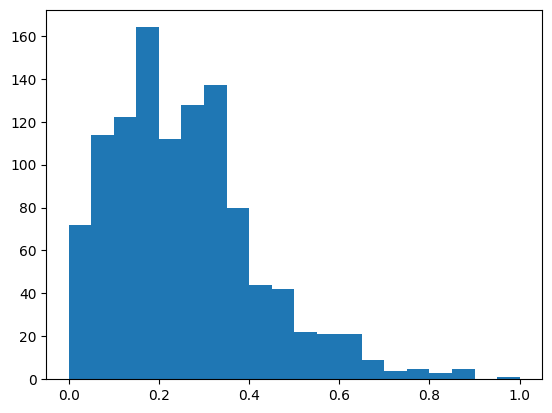

In [162]:
fig, ax = plt.subplots()

ax.hist(corr_tracker.values(), bins=20)

In [93]:
print("Full complex: ", len(full_complex) / len(complex_info))
print("Partial complex: ", len(partial_complex) / len(complex_info))
print("Any complex: ", (len(partial_complex) + len(full_complex)) / len(complex_info))

Full complex:  0.0921235736153632
Partial complex:  0.46061786807681604
Any complex:  0.5527414416921792


### What about in INDRA networks

#### Load INDRA network

In [94]:
indra_network = pd.read_csv("../../data/INDRA_networks/Talus_networks/MORF_CCNI_obs.tsv", sep="\t")

In [95]:
indra_proteins = list(set(list(indra_network["source_hgnc_symbol"]) + list(indra_network["target_hgnc_symbol"])))

#### Check out overlap

In [96]:
full_complex = list()
partial_complex = list()
percentage_tracker = list()

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
    
for i in range(len(complex_info)):
    genes = complex_info.loc[i, "subunits(Gene name)"].split(";")
    overlap = intersection(genes, indra_proteins)

    if len(overlap) == len(genes):
        full_complex.append(complex_info.loc[i, "ComplexID"])
        percentage_tracker.append(1.)
    elif len(overlap) > 0:
        partial_complex.append(complex_info.loc[i, "ComplexID"])
        percentage_tracker.append(len(overlap) / len(genes))

(array([ 13.,  30.,  26.,  47.,  72.,   6., 254.,  14.,   7., 193.,   0.,
         11.,   2.,  70.,   5.,   4.,   0.,   0.,   0.,  61.]),
 array([0.00961538, 0.05913462, 0.10865385, 0.15817308, 0.20769231,
        0.25721154, 0.30673077, 0.35625   , 0.40576923, 0.45528846,
        0.50480769, 0.55432692, 0.60384615, 0.65336538, 0.70288462,
        0.75240385, 0.80192308, 0.85144231, 0.90096154, 0.95048077,
        1.        ]),
 <BarContainer object of 20 artists>)

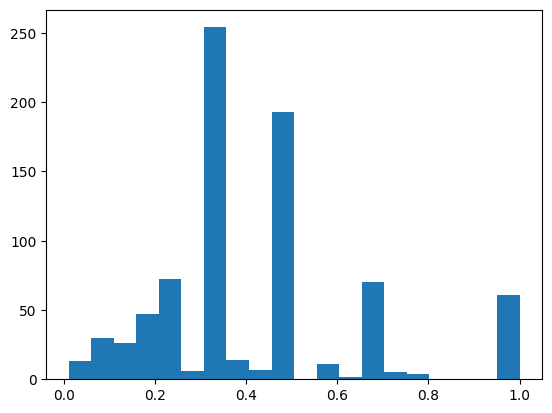

In [97]:
fig, ax = plt.subplots()

ax.hist(percentage_tracker, bins=20)

In [98]:
print("Full complex: ", len(full_complex))
print("Partial complex: ", len(partial_complex))
print("Any complex: ", (len(partial_complex) + len(full_complex)))

Full complex:  61
Partial complex:  754
Any complex:  815


## Calculate correlation between multiple variables

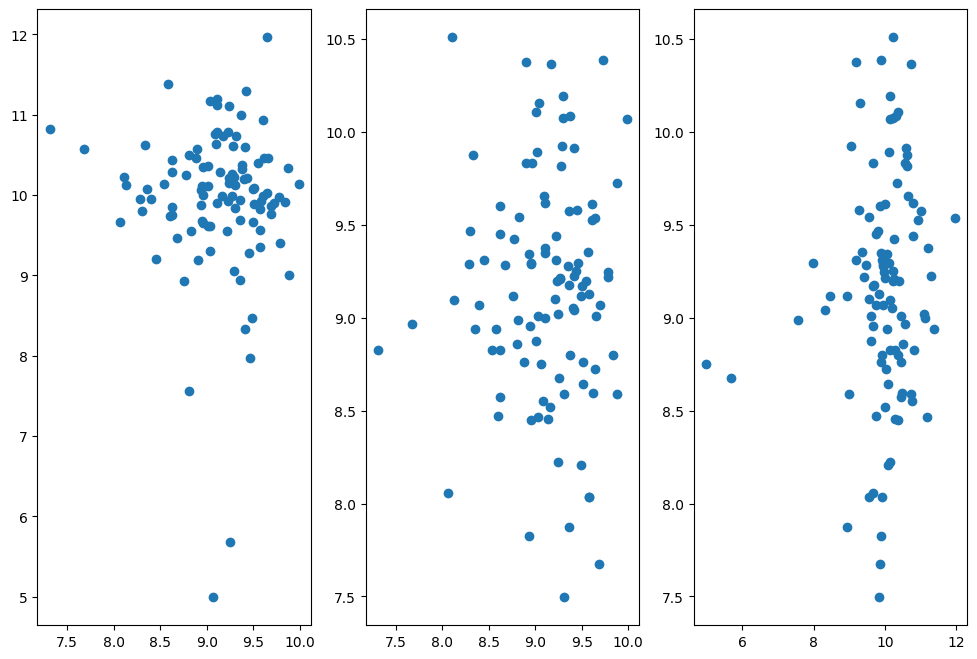

In [185]:
temp_genes = complex_info.loc[complex_info["ComplexID"] == 12, 
                                  "subunits(Gene name)"].values[0].split(";")
dataz = experimental_data.loc[:, temp_genes].dropna().values

fig, ax = plt.subplots(1,3, figsize=(12,8))

ax[0].scatter(dataz[:, 0], dataz[:, 1])
ax[1].scatter(dataz[:, 0], dataz[:, 2])
ax[2].scatter(dataz[:, 1], dataz[:, 2])

In [181]:
full_complex[0]

12

In [196]:
pca_corr = list()

for i in full_complex:
    temp_genes = complex_info.loc[complex_info["ComplexID"] == i, 
                                  "subunits(Gene name)"].values[0].split(";")
    pca = PCA(n_components=1)
    pca.fit(experimental_data.loc[:, temp_genes].dropna().values)
    pca_corr.append(pca.explained_variance_)

(array([74., 91., 54., 42., 23., 14.,  3.,  6.,  8.,  6.,  1.,  2.,  3.,
         0.,  2.,  0.,  0.,  0.,  0.,  2.]),
 array([0.04469909, 0.14839656, 0.25209402, 0.35579148, 0.45948894,
        0.56318641, 0.66688387, 0.77058133, 0.87427879, 0.97797626,
        1.08167372, 1.18537118, 1.28906865, 1.39276611, 1.49646357,
        1.60016103, 1.7038585 , 1.80755596, 1.91125342, 2.01495088,
        2.11864835]),
 <BarContainer object of 20 artists>)

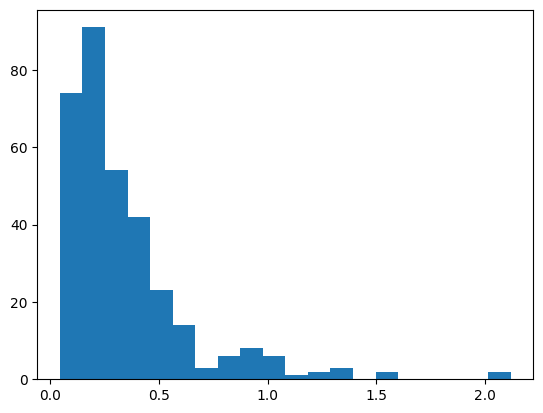

In [197]:
fig, ax = plt.subplots()
ax.hist(np.array(pca_corr), bins=20)

## Algorithm to include complexes in graph

    Input: Nodes, Complexes, Correlations, correlation_cutoff, partial_obs_cutoff

    Nodes - List of proteins in graph
    Complexes - List of lists including all possible protein complexes in Nodes
    Correlations - Matrix of correlations within complexes
    correlation_cutoff - Cutoff for including
    partial_obs_cutoff - Cutoff for how many nodes in a complex to keep

    present_complexes = list()
    
    for c in Complexes:
    
        overlap = intersect(c, nodes)
    
        // Check if full complex is available
        if len(overlap) == len(c) & Correlations[c] > coorelation_cutoff:
            present_complexes.append(c)

        elif len(overlap) / len(c) > partial_obs_cutoff & Correlations[c] > coorelation_cutoff:
            present_complexes.append(c)
        
        




edges cases:
- what if complex is partially observed but high correlation (where is cutoff)
- what if complex is fully observed but low correlation (where is cutoff)
- what if there are multiple complexes including same nodes?

## Open Qs

### Connections in INDRA with Up/Down events

Make indra into a networkx graph

In [105]:
G = nx.DiGraph()
for i in range(len(indra_network)):
    G.add_edge(indra_network.loc[i, "source_hgnc_symbol"],
               indra_network.loc[i, "target_hgnc_symbol"])

None
['SPI1', 'HDAC1', 'SIN3A']
None
['RB1', 'DNMT1', 'E2F1', 'HDAC1']
None
['BRCA1', 'HDAC1', 'HDAC2']
None
['HDAC1', 'HDAC2', 'SIN3A']
None
['RB1', 'HDAC1']


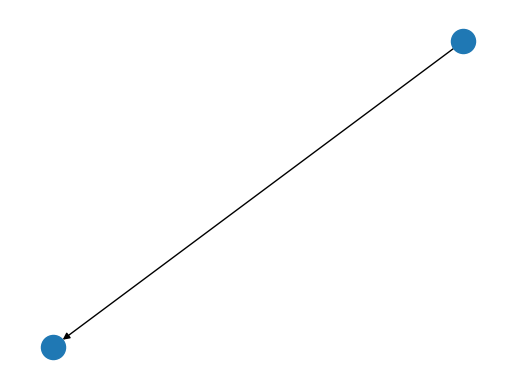

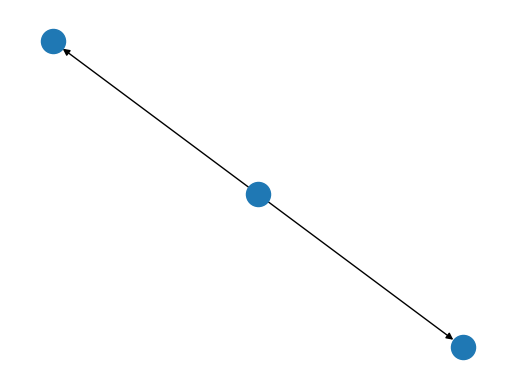

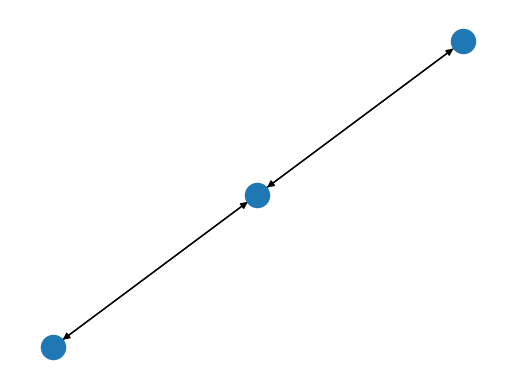

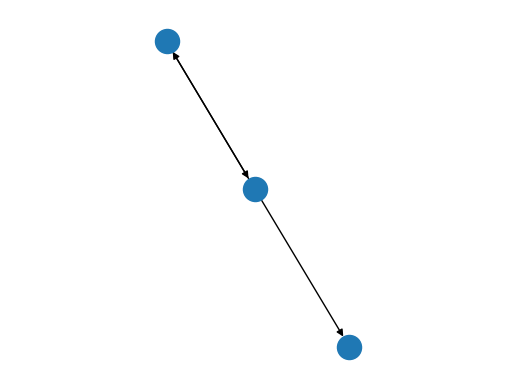

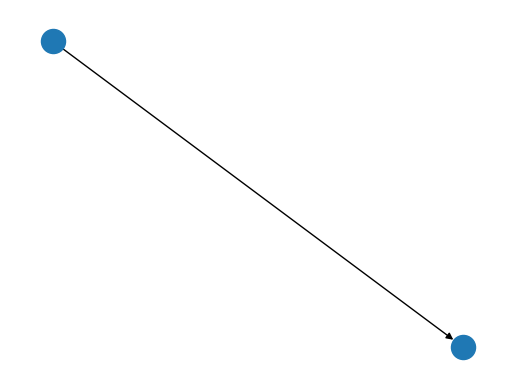

In [111]:
for i in range(len(full_complex)):
    genes = complex_info.loc[complex_info["ComplexID"] == full_complex[i], 
                "subunits(Gene name)"].values[0].split(";")
    
    subset_net = indra_network[indra_network["source_hgnc_symbol"].isin(genes) & 
                               indra_network["target_hgnc_symbol"].isin(genes)].reset_index(drop=True)
    
    if len(subset_net) > 0:
        G = nx.DiGraph()
        for i in range(len(subset_net)):
            G.add_edge(subset_net.loc[i, "source_hgnc_symbol"],
                       subset_net.loc[i, "target_hgnc_symbol"])
        fig, ax = plt.subplots()
        print(nx.draw(G))
        print(genes)